## Step 6: Worker Performance Segmentation & Dashboard Preparation

This notebook performs:
1. **Worker segmentation** based on SLA compliance, accuracy, task count, and learning trends.
2. Prepares a **dashboard-ready dataset** for interactive Streamlit visualization.
3. Highlights **top performers, at-risk workers, and high-impact contributors**.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Load synthetic dataset
df = pd.read_csv("simulated_worker_tasks.csv", parse_dates=["task_date"])
df.head()

,task_id,worker_id,task_date,task_complexity,time_taken_minutes,accuracy
0,77016b53-3aa3-497a-b042-4246e5a9583e,W_001,2024-01-01,Low,5.28,0.990
1,7f65a185-9675-4d6d-974c-c0b27805270a,W_001,2024-01-01,Medium,7.30,0.946
2,a78aa64d-4a37-4105-baab-125b5d293c4e,W_001,2024-01-01,Low,4.43,0.952
3,2d08d6c7-c351-40f4-af67-5a62f3a250ce,W_001,2024-01-01,Medium,5.41,0.913
4,c236a814-63f0-4035-8e30-b4642282a1d8,W_001,2024-01-01,Medium,7.36,0.908


## Compute Daily SLA Compliance

- Use **calibrated SLA thresholds** (from Step 4) for accuracy and task count.
- Determine **daily worker compliance**.

In [11]:
# Daily stats per worker
daily_stats = df.groupby(['worker_id', 'task_date']).agg(
    tasks_completed=('task_id','count'),
    avg_accuracy=('accuracy','mean')
).reset_index()

daily_stats.head()

,worker_id,task_date,tasks_completed,avg_accuracy
0,W_001,2024-01-01,18,0.955167
1,W_001,2024-01-02,17,0.941176
2,W_001,2024-01-03,13,0.932769
3,W_001,2024-01-04,12,0.945667
4,W_001,2024-01-05,21,0.934905


In [12]:
# Accuracy threshold
accuracy_sla_calibrated = daily_stats['avg_accuracy'].quantile(0.75)
# Task count threshold
task_count_sla_calibrated = daily_stats['tasks_completed'].quantile(0.70)

print(f"Calibrated Accuracy SLA: {accuracy_sla_calibrated:.2f}")
print(f"Calibrated Task Count SLA: {task_count_sla_calibrated:.0f}")

# Daily stats per worker
daily_stats = df.groupby(['worker_id','task_date']).agg(
    tasks_completed=('task_id','count'),
    avg_accuracy=('accuracy','mean')
).reset_index()

daily_stats['accuracy_sla_met'] = daily_stats['avg_accuracy'] >= accuracy_sla_calibrated
daily_stats['task_count_sla_met'] = daily_stats['tasks_completed'] >= task_count_sla_calibrated
daily_stats['overall_sla_met'] = daily_stats['accuracy_sla_met'] & daily_stats['task_count_sla_met']

Calibrated Accuracy SLA: 0.95
Calibrated Task Count SLA: 17


## Aggregate Worker Metrics

- Calculate **average accuracy, total tasks, SLA compliance percentage, and cumulative learning trends** per worker.

In [14]:
worker_metrics = daily_stats.groupby('worker_id').agg(
    total_tasks=('tasks_completed','sum'),
    avg_accuracy=('avg_accuracy','mean'),
    days_sla_met=('overall_sla_met','sum'),
    total_days=('task_date','nunique')
).reset_index()

worker_metrics['sla_pct'] = (worker_metrics['days_sla_met']/worker_metrics['total_days']*100).round(2)

# Sort by SLA compliance & task count
worker_metrics = worker_metrics.sort_values(['sla_pct','total_tasks'], ascending=[False,False])
worker_metrics.head()

,worker_id,total_tasks,avg_accuracy,days_sla_met,total_days,sla_pct
47,W_048,467,0.943374,6,30,20.00
46,W_047,474,0.940853,5,30,16.67
43,W_044,427,0.938912,4,30,13.33
22,W_023,466,0.939045,3,30,10.00
5,W_006,465,0.939660,3,30,10.00


## Worker Segmentation

- Segment workers into **Top, Mid, Low performers** using quantiles on SLA compliance and total tasks.  
- Provides actionable insights for **incentives, training, and task allocation**.

In [15]:
# SLA compliance quantiles
top_thresh = worker_metrics['sla_pct'].quantile(0.75)
low_thresh = worker_metrics['sla_pct'].quantile(0.25)

def segment_worker(row):
    if row['sla_pct'] >= top_thresh:
        return 'Top Performer'
    elif row['sla_pct'] <= low_thresh:
        return 'Low Performer'
    else:
        return 'Mid Performer'

worker_metrics['performance_segment'] = worker_metrics.apply(segment_worker, axis=1)
worker_metrics.head()

,worker_id,total_tasks,avg_accuracy,days_sla_met,total_days,sla_pct,performance_segment
47,W_048,467,0.943374,6,30,20.00,Top Performer
46,W_047,474,0.940853,5,30,16.67,Top Performer
43,W_044,427,0.938912,4,30,13.33,Top Performer
22,W_023,466,0.939045,3,30,10.00,Top Performer
5,W_006,465,0.939660,3,30,10.00,Top Performer


In [24]:
worker_metrics.sort_values('days_sla_met').head(10)

,worker_id,total_tasks,avg_accuracy,days_sla_met,total_days,sla_pct,performance_segment
33,W_034,464,0.940181,0,30,0.0,Low Performer
16,W_017,451,0.934433,0,30,0.0,Low Performer
10,W_011,450,0.937051,0,30,0.0,Low Performer
4,W_005,440,0.938488,0,30,0.0,Low Performer
49,W_050,434,0.937244,0,30,0.0,Low Performer
8,W_009,429,0.939326,0,30,0.0,Low Performer
15,W_016,415,0.941144,0,30,0.0,Low Performer
30,W_031,413,0.937529,0,30,0.0,Low Performer
37,W_038,428,0.936202,0,30,0.0,Low Performer
27,W_028,421,0.939714,0,30,0.0,Low Performer


In [17]:
# Save dashboard-ready CSV
dashboard_df = worker_metrics.copy()
dashboard_df.to_csv("dashboard_worker_metrics.csv", index=False)
dashboard_df.head()

,worker_id,total_tasks,avg_accuracy,days_sla_met,total_days,sla_pct,performance_segment
47,W_048,467,0.943374,6,30,20.00,Top Performer
46,W_047,474,0.940853,5,30,16.67,Top Performer
43,W_044,427,0.938912,4,30,13.33,Top Performer
22,W_023,466,0.939045,3,30,10.00,Top Performer
5,W_006,465,0.939660,3,30,10.00,Top Performer


## Visualization

- Plot **worker SLA compliance by performance segment**.

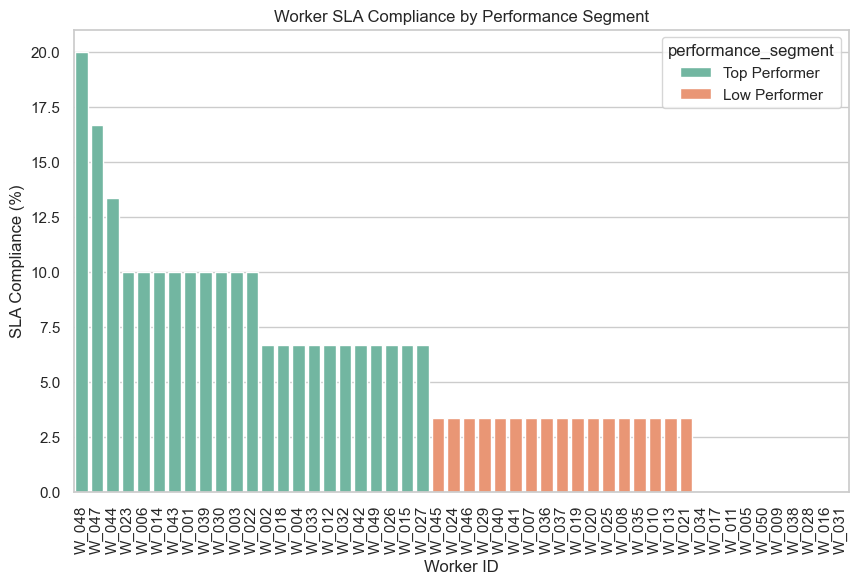

In [18]:
plt.figure(figsize=(10,6))
sns.barplot(data=dashboard_df, x='worker_id', y='sla_pct', hue='performance_segment', dodge=False, palette='Set2')
plt.xticks(rotation=90)
plt.ylabel("SLA Compliance (%)")
plt.xlabel("Worker ID")
plt.title("Worker SLA Compliance by Performance Segment")
plt.show()

## Key Insights

1. **Top Performers** consistently meet SLA and handle high task volume.  
2. **Mid Performers** meet SLA occasionally and may require guidance or incentives.  
3. **Low Performers** struggle to meet SLA; targeted **training, mentoring, or task adjustments** are needed.  
4. This **dashboard-ready dataset** supports **Streamlit interactive visualizations** for stakeholders to explore trends and make decisions.